In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [182]:
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


Get the relations of the graph

In [184]:
import kgbench as kg
from src.rgcn_explainer_utils import *

data = kg.load('aifb', torch=True, final=False)
get_relations(data)
relations = [data.i2rel[i][0] for i in range(len(data.i2rel))]


loaded data aifb (0.2106s).


In [627]:
###functions
def keep_columns_with_non_zero_values(df):
    ''' Keep only columns with non-zero values'''

    df = df.fillna(0)
    # Get the column names with non-zero values
    non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

    # Create a new DataFrame with only the columns containing non-zero values
    modified_df = df[non_zero_columns]

    return modified_df

def analysis(path,columns):
    ''' Create df to compare predictions original vs explain'''
    df = pd.read_csv(path+'/Relations_Important_aifb_full.csv', sep=',')
    df.drop(columns=['type.1', 'type.2'], inplace=True)

    for i in columns:
        df[i]/=2
    df.set_index('node_idx', inplace=True)

    df['label'] = df['label'].apply(lambda x: int(x[1])) 


    df['tot'] = df[columns].sum(axis=1)
    sum_per_group = df.groupby('label')[columns].sum()
    tot_class = sum_per_group.mean(axis=1)
    std_class = sum_per_group.std(axis=1)
    

    result = df[columns].div(df['number_neighbors'], axis=0) 
    result['label']= df.label
    #result = df[columns].div(df['number_neighbors'], axis=0)

    result = keep_columns_with_non_zero_values(result)
    result.drop(columns=['type'], inplace=True)
    gb = result.groupby('label') 

    a = gb.aggregate(['mean'])

    max_rows = a.idxmax()
    print('Average explanation lenght:', df['tot'].mean(), 'std:', df['tot'].std())

    df['total_notype'] = df['tot']-df['type']
    print('Average explanation lenght without type:', df['total_notype'].mean(), 'std:', df['total_notype'].std())
    columns_no_type = list(filter(lambda x: x != 'type', columns))
    print('columns_no_type', columns_no_type)
    sum_per_group_no_type = df.groupby('label')[columns_no_type].sum()
    tot_class_no_type = sum_per_group_no_type.mean(axis=1)
    std_class_no_type = sum_per_group_no_type.std(axis=1)
    result_dict = {}
    for column, value in max_rows.items():
        if value in result_dict:
            result_dict[value].append(column[0])
        else:
            result_dict[value] = [column[0]]
    for i in set(df['label']):
        if i not in result_dict.keys():
            result_dict[i] = ''
    d = {int(key): value for key, value in result_dict.items()}


    d = dict(sorted(d.items()))
 
    pd.set_option('display.max_colwidth', None)
    d = pd.DataFrame(list(d.items()), columns=['Label', 'Relation'])
    d = d.set_index('Label')
    d['Exp mean length'] = np.round(tot_class,3)
    d['Exp std length'] = np.round(std_class,3)
    d['Exp mean length without type'] = np.round(tot_class_no_type,3)
    d['Exp std length without type'] = np.round(std_class_no_type,3)


    return df, a, max_rows,d





def full_vs_explain(df, binary=False):
    ''' Create df to compare predictions original vs explain'''
    mismatch = {}
    matc = {}
    for index, row in df.iterrows():
        if binary:
            obj = row['prediction_explain_binary']
        else:
            obj = row['prediction_explain']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        explain = np.argmax(my_list)
        
        original = int(row['label'])
        if original == explain:
            if original in matc:
                matc[original].append(index)
            else:
                matc[original] = [index] 

        elif original != explain:
            if original in mismatch:
                mismatch[original].append(index)
            else:
                mismatch[original] = [index]

    accuracy = {}
    labels = [int(i) for i in set(df['label'])]



    for i in labels:
        if i not in mismatch.keys():
            accuracy[int(i)] = 1
        if i not in matc.keys():
            accuracy[int(i)] = 0
        if i in mismatch.keys() and i in matc.keys():
            accuracy[int(i)] = len(matc[i])/(len(matc[i])+len(mismatch[i]))
    accuracy = {int(key): value for key, value in accuracy.items()}
    accuracy = dict(sorted(accuracy.items()))
    print(f"Accuracy with Binary {binary}: {accuracy}")

    accuracy = list(accuracy.values())
    return mismatch, matc, accuracy


def result_table(path, relations):
    df, a, max_rows,d = analysis(path,relations)
    mismatch, match, accuracy = full_vs_explain(df)
    mismatch, match, accuracy_binary = full_vs_explain(df, binary=True)
    d['Accuracy'] = np.round(accuracy,3)
    d['Accuracy_binary'] = np.round(accuracy_binary,3)
    table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
    latex_table = table.replace('\\midrule', '\\hline')
    latex_table = latex_table.replace('\\toprule', '\\hline')
    latex_table = latex_table.replace('\\bottomrule', '\\hline')
    latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
    latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
    
    return latex_table




Experiment 0: 

In [631]:
path = 'chk/aifb_chk/0_hops_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/Relation_Importance'

d = result_table(path,relations)
print(d)
 


Average explanation lenght: 12.778571428571428 std: 11.145721189781131
Average explanation lenght without type: 12.710526315789474 std: 11.612153343078013
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 0.7857142857142857, 1: 0, 2: 0.8181818181818182, 3: 0.16666666666666666}
Accuracy with Binary True: {0: 0.5714285714285714, 1: 0, 2: 0.7272727272727273, 3: 0.16666666666666666}
\begin{table}
\centering
\caption{0-hops-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-normal}
\label{Relation-Importance}
\begin

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1368766398.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experiment 2

In [614]:
path = 'chk/aifb_chk/2_hops_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 865.3928571428571 std: 347.07082196892446
Average explanation lenght without type: 655.6714285714286 std: 327.65386917171185
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.8181818181818182, 3: 0.6666666666666666}
Accuracy with Binary True: {0: 1, 1: 1, 2: 0.8181818181818182, 3: 0.8333333333333334}
\begin{table}
\centering
\caption{2-hops-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-normal}
\label{2-hops-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-normal}
\be

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experiment 3

In [615]:
path = 'chk/aifb_chk/hops_2_size_0.0005_lr_0.1_epochs_30_threshold_0.5_init_const_exp_adaptive_new/Relation_Importance'
d = result_table(path,relations)


print(d)


Average explanation lenght: 574.8357142857143 std: 158.6282875575645
Average explanation lenght without type: 431.8142857142857 std: 158.0526292519216
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.9090909090909091, 3: 0.6666666666666666}
Accuracy with Binary True: {0: 0.7142857142857143, 1: 1, 2: 1, 3: 0.5}
\begin{table}
\centering
\caption{hops-2-size-0.0005-lr-0.1-epochs-30-threshold-0.5-init-const-exp-adaptive-new}
\label{hops-2-size-0.0005-lr-0.1-epochs-30-threshold-0.5-init-const-exp-

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experiment 4

In [617]:
path = 'chk/aifb_chk/hops_2_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal_exp_type_loss/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 646.95 std: 413.10977123306503
Average explanation lenght without type: 496.1857142857143 std: 370.3881923404283
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.8181818181818182, 3: 0.6666666666666666}
Accuracy with Binary True: {0: 1, 1: 0.5, 2: 0.7272727272727273, 3: 0.3333333333333333}
\begin{table}
\centering
\caption{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-normal-exp-type-loss}
\label{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-normal-

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experiment 5

In [626]:
path = 'chk/aifb_chk/hops_2_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_zero_out_exp_type_loss/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 22.21785714285714 std: 72.41897946798805
Average explanation lenght without type: 17.7265625 std: 52.5778746309286
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 0.25, 2: 0.7272727272727273, 3: 0.3333333333333333}
Accuracy with Binary True: {0: 1, 1: 0, 2: 0, 3: 0}
\begin{table}
\centering
\caption{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-zero-out-exp-type-loss}
\label{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-zero-out-exp-type-loss}
\begin{adjus

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experiment 6

In [619]:
path = 'chk/aifb_chk/hops_2_size_0.0005_lr_0.1_epochs_30_threshold_0.5_init_normal_exp_adaptive_new/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 347.8357142857143 std: 234.96870053497005
Average explanation lenght without type: 252.55714285714285 std: 182.07499955288995
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 0.5, 2: 0.8181818181818182, 3: 0}
Accuracy with Binary True: {0: 0.7142857142857143, 1: 0.25, 2: 0.6363636363636364, 3: 0}
\begin{table}
\centering
\caption{hops-2-size-0.0005-lr-0.1-epochs-30-threshold-0.5-init-normal-exp-adaptive-new}
\label{hops-2-size-0.0005-lr-0.1-epochs-30-threshold-0.5-init-nor

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experiment 7

In [620]:
path = 'chk/aifb_chk/hops_2_size_0.0005_lr_0.1_epochs_30_threshold_0.5_init_normal_exp_/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 483.65714285714284 std: 177.74493338640573
Average explanation lenght without type: 360.8857142857143 std: 136.02989970387165
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 0.75, 2: 0.8181818181818182, 3: 0.6666666666666666}
Accuracy with Binary True: {0: 0.5714285714285714, 1: 0.5, 2: 0.8181818181818182, 3: 0.16666666666666666}
\begin{table}
\centering
\caption{hops-2-size-0.0005-lr-0.1-epochs-30-threshold-0.5-init-normal-exp-}
\label{hops-2-size-0.0005-lr-0.1-epochs-30

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experiment 8

In [621]:
path = 'chk/aifb_chk/hops_2_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_overall_frequency_exp_/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 816.8214285714286 std: 371.1390335816204
Average explanation lenght without type: 596.5 std: 314.78178716280866
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.8181818181818182, 3: 0.8333333333333334}
Accuracy with Binary True: {0: 0.7142857142857143, 1: 0.5, 2: 0.6363636363636364, 3: 0.3333333333333333}
\begin{table}
\centering
\caption{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-overall-frequency-exp-}
\label{hops-2-size-0.005-lr-0.1-epochs-30-threshol

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


Experimemt 9

In [622]:
path = 'chk/aifb_chk/hops_2_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_inverse_relative_frequency_exp_/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 223.9 std: 172.0690823990384
Average explanation lenght without type: 191.17142857142858 std: 143.41024774981693
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.9090909090909091, 3: 0.8333333333333334}
Accuracy with Binary True: {0: 0.9285714285714286, 1: 0.5, 2: 0.6363636363636364, 3: 0.5}
\begin{table}
\centering
\caption{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-inverse-relative-frequency-exp-}
\label{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [623]:
path = 'chk/aifb_chk/hops_2_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal_exp_no_binary/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 43.792857142857144 std: 10.096134546107695
Average explanation lenght without type: 32.838235294117645 std: 5.943828717396464
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.8181818181818182, 3: 0.6666666666666666}
Accuracy with Binary True: {0: 0.9285714285714286, 1: 0, 2: 0.45454545454545453, 3: 0}
\begin{table}
\centering
\caption{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-normal-exp-no-binary}
\label{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1034868383.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-1].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [628]:
path = 'chk/aifb_chk/hops_2_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal_exp_no_binary/Relation_Importance'
d = result_table(path,relations)


print(d)

Average explanation lenght: 7.521428571428571 std: 2.14854724223156
Average explanation lenght without type: 5.485294117647059 std: 1.4367223541779575
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.8181818181818182, 3: 0.6666666666666666}
Accuracy with Binary True: {0: 1, 1: 0, 2: 0.2727272727272727, 3: 0}
\begin{table}
\centering
\caption{hops-2-size-0.005-lr-0.1-epochs-30-threshold-0.5-init-normal-exp-no-binary}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|c|

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1368766398.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [629]:
path = 'chk/aifb_chk/hops_2_size_5e-05_lr_0.1_epochs_30_threshold_0.5_init_const_exp_no_binary/Relation_Importance'
d = result_table(path,relations)


print(d)


Average explanation lenght: 540.2285714285714 std: 147.72227608197872
Average explanation lenght without type: 406.3142857142857 std: 147.9977188672716
columns_no_type ['abstract', 'address', 'author', 'booktitle', 'carriedOutBy', 'carriesOut', 'chapter', 'dealtWithIn', 'edition', 'editor', 'fax', 'financedBy', 'finances', 'hasProject', 'head', 'homepage', 'howpublished', 'isAbout', 'isWorkedOnBy', 'isbn', 'journal', 'member', 'month', 'name', 'note', 'number', 'pages', 'phone', 'photo', 'projectInfo', 'publication', 'publishes', 'series', 'title', 'volume', 'worksAtProject', 'year', 'range', 'subClassOf', 'allValuesFrom', 'inverseOf', 'onProperty']
Accuracy with Binary False: {0: 1, 1: 1, 2: 0.9090909090909091, 3: 0.8333333333333334}
Accuracy with Binary True: {0: 1, 1: 1, 2: 0.9090909090909091, 3: 0.8333333333333334}
\begin{table}
\centering
\caption{hops-2-size-5e-05-lr-0.1-epochs-30-threshold-0.5-init-const-exp-no-binary}
\label{Relation-Importance}
\begin{adjustbox}{scale=0.5}\beg

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_47018/1368766398.py:140: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-1].replace('_','-'),column_format='|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [132]:
# Read in the data
path = 'Relation_Importance_aifb/2_hops_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal'
df = pd.read_csv(path+'/Relations_Important_aifb_full.csv', sep=',')
df.set_index('node_idx', inplace=True)

df['label'] = df['label'].apply(lambda x: x[1]) 
columns = relations


gb = df.groupby('label')   

df['tot'] = df[columns].sum(axis=1)
result = df[columns].div(df['tot'], axis=0) 
result = df[columns].div(df['number_neighbors'], axis=0)
result['label']= df.label
result.head(5)

result = keep_columns_with_non_zero_values(result)
#result.drop(columns=['type'], inplace=True)
gb = result.groupby('label') 

a = gb.aggregate(['mean', 'std'])

max_rows = a.idxmax()

max_rows
a


author              editor                 fax            homepage  \
           mean       std      mean       std      mean       std      mean   
label                                                                         
0      0.016272  0.025921  0.000251  0.000938  0.149678  0.088999  0.014212   
1      0.028380  0.021067  0.000000  0.000000  0.091000  0.098383  0.000900   
2      0.198416  0.238441  0.006316  0.017797  0.064998  0.090023  0.000912   
3      0.026864  0.024777  0.000000  0.000000  0.169238  0.074628  0.000000   

                isWorkedOnBy            ...      name               phone  \
            std         mean       std  ...      mean       std      mean   
label                                   ...                                 
0      0.019511     0.013427  0.024975  ...  0.001726  0.000882  0.075706   
1      0.001039     0.024224  0.024328  ...  0.001371  0.000915  0.002275   
2      0.001704     0.065786  0.062239  ...  0.001354  0.000690  0.005036   
3      0.000000     0.022351  0.023330  ...  0.001218  0.000944  0.055706   

                    photo           publication           worksAtProject  \
            std      mean       std        mean       std           mean   
label                                                                      
0      0.056242  0.000125  0.000467    0.014725  0.024364       0.001765   
1      0.000889  0.000904  0.001044    0.025232  0.019116       0.008104   
2      0.005185  0.000879  0.000855    0.198180  0.256003       0.022623   
3      0.059527  0.001526  0.000748    0.024172  0.022694       0.007874   

                 
            std  
label            
0      0.004014  
1      0.006664  
2      0.025626  
3      0.006896  

[4 rows x 22 columns]

In [141]:
import numpy as np

def full_vs_explain(df):
    mismatch = []
    match = []
    for index, row in df.iterrows():
        obj = row['prediction_explain_binary']
        #obj = row['prediction_explain']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        explain = np.argmax(my_list)
        
        obj = row['prediction_full']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        full = np.argmax(my_list)
        original = row['label']

        if full == explain:
            #print(f"Row {index}: Full and explain match.")
            match.append(index)
        elif original != explain:
            #print(f"Row {index}: Full and explain differ.")
            mismatch.append(index)
        elif full == explain != row['label']:
            print(f"Row {index}: Full and explain match but not label.")
        elif full != explain == row['label']:
            print(f"Row {index}: Full and explain differ but explain match label.")
    print(f"Total mismatch: {len(mismatch)}")
    print(f"Mismatch: {mismatch}")
    print(f"Accuracy: {len(match)/(len(match)+len(mismatch))}")
    return mismatch, match



mismatch, match = full_vs_explain(df)


Total mismatch: 3
Mismatch: [5783, 5839, 5844]
Accuracy: 0.9142857142857143


In [62]:
selected_rows = df.loc[mismatch]['number_neighbors']
print('num neighbors for wrong ones',selected_rows)

labels = df.loc[mismatch]['label']
print('labels for wrong ones',labels)

types = df.loc[mismatch]['type']
print('types for wrong ones',types)


df.loc[mismatch]

num neighbors for wrong ones node_idx
5783    1078
5905    1056
5785    1109
5831    1115
5839    1087
5844    1067
5752    1119
5795    1080
5854    1136
Name: number_neighbors, dtype: int64
labels for wrong ones node_idx
5783    [0]
5905    [1]
5785    [1]
5831    [2]
5839    [2]
5844    [2]
5752    [3]
5795    [3]
5854    [3]
Name: label, dtype: object
types for wrong ones node_idx
5783     672
5905     718
5785     748
5831     756
5839     968
5844    2090
5752     808
5795     716
5854    1080
Name: type, dtype: int64


In [16]:
df_rel = df.iloc[:,1:].div(df.tot, axis=0)
df_rel['label'] = df['label']

df_rel.dropna(axis=1, how='all')


,author,carriedOutBy,carriesOut,dealtWithIn,editor,fax,hasProject,homepage,isAbout,isWorkedOnBy,...,photo,projectInfo,publication,publishes,type,worksAtProject,type.1,type.2,tot,label
node_idx,,,,,,,,,,,,,,,,,,,,,
5678,0.103448,0.017241,0.017241,0.086207,0.017241,0.017241,0.051724,0.017241,0.086207,0.068966,...,0.017241,0.051724,0.155172,0.172414,0.017241,0.017241,0.017241,0.017241,1.0,0
5724,0.125000,NaN,NaN,NaN,NaN,0.125000,NaN,0.125000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.125000,NaN,0.125000,0.125000,1.0,0
5699,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,0.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5688,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5702,0.250000,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5714,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5708,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,0.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5843,0.181818,NaN,NaN,0.045455,NaN,0.045455,0.090909,NaN,0.272727,0.136364,...,NaN,0.045455,0.090909,NaN,NaN,NaN,NaN,NaN,1.0,0
5873,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0


In [31]:
from collections import Counter
Counter(df_rel['label'])

Counter({0: 14, 1: 4, 2: 11, 3: 6})

In [37]:
#select one row of df according to node_idx index value
df_rel.loc[5757].sort_values()



name              0.0625
type              0.0625
type.1            0.0625
type.2            0.0625
publication       0.2500
author            0.3750
tot               1.0000
label             2.0000
abstract             NaN
address              NaN
booktitle            NaN
carriedOutBy         NaN
carriesOut           NaN
chapter              NaN
dealtWithIn          NaN
edition              NaN
editor               NaN
fax                  NaN
financedBy           NaN
finances             NaN
hasProject           NaN
head                 NaN
homepage             NaN
howpublished         NaN
isAbout              NaN
isWorkedOnBy         NaN
isbn                 NaN
journal              NaN
member               NaN
month                NaN
note                 NaN
number               NaN
pages                NaN
phone                NaN
photo                NaN
projectInfo          NaN
publishes            NaN
series               NaN
title                NaN
volume               NaN


In [39]:
a = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/mdgenre_chk/prediction_mdgenre_prune_False')
a.shape

torch.Size([3000, 12])

In [28]:
for i in np.unique(df_rel['label']):
    exec(f'group_{i} = gb.get_group(i)')
    exec(f'group_rel_{i} = group_{i}.iloc[:,1:].div(group_{i}.tot, axis=0)')
    exec(f'group_rel_{i} = group_rel_{i}.drop(columns=["tot"])')
    exec(f'group_max_{i} = group_rel_{i}.idxmax(axis=1)')

#group_rel_0
print('group_max_0: \n', group_max_0.value_counts(),
      '\n group_max_1 \n', group_max_1.value_counts(),#,
         '\n group_max_2 \n', group_max_2.value_counts(),
         '\n group_max_3 \n', group_max_3.value_counts())

group_max_0: 
 fax            7
author         4
publishes      1
isAbout        1
dealtWithIn    1
dtype: int64 
 group_max_1 
 isAbout    2
author     2
dtype: int64 
 group_max_2 
 author         5
isAbout        3
hasProject     1
projectInfo    1
publication    1
dtype: int64 
 group_max_3 
 isAbout        3
author         1
publication    1
fax            1
dtype: int64


In [29]:
print('group_max_0: \n', group_max_0.value_counts, )

group_max_0: 
 <bound method IndexOpsMixin.value_counts of node_idx
5678      publishes
5724         author
5699            fax
5688            fax
5702         author
5714            fax
5708            fax
5843        isAbout
5873            fax
5697            fax
5783         author
5701            fax
5845    dealtWithIn
5778         author
dtype: object>


In [17]:
from dfply import *
# summary statistics for dependent variable AUTHOR
df_rel >> group_by(X.label) >> summarize(n=X['author'].count(), mean=X['author'].mean(), std=X['author'].std())
# output

,label,n,mean,std
0,0,7,0.195746,0.095461
1,1,4,0.151612,0.025134
2,2,11,0.176738,0.125399
3,3,4,0.132441,0.019422


In [18]:
from dfply import *
# summary statistics for dependent variable AUTHOR
df_rel >> group_by(X.label) >> summarize(n=X['dealtWithIn'].count(), mean=X['dealtWithIn'].mean(), std=X['dealtWithIn'].std())
# output

,label,n,mean,std
0,0,3,0.092372,0.050284
1,1,1,0.032258,NaN
2,2,5,0.026256,0.017000
3,3,1,0.055556,NaN


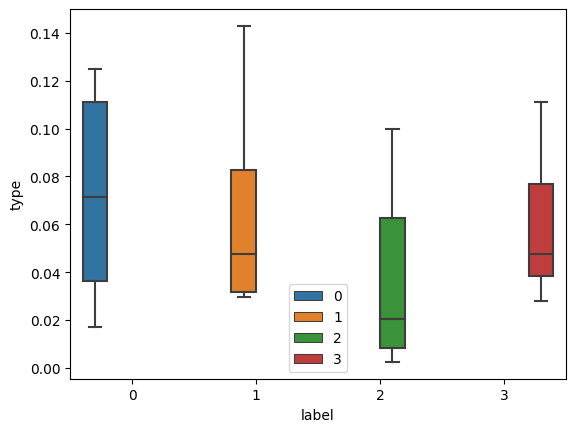

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
#fig, axs = plt.subplots(ncols=2)
sns.boxplot(data=df_rel, x="label", y="type",  hue=df.label.tolist())
#sns.boxplot(data=df_rel, x="plant_var", y="canopy_vol", hue=df.plant_var..tolist(), ax=axs[1])
plt.show()

In [20]:
from statsmodels.multivariate.manova import MANOVA
fit = MANOVA.from_formula('author + fax ~ label', data=df)
print(fit.mv_test())

                                Multivariate linear model
                                                                                         
-----------------------------------------------------------------------------------------
       Intercept                Value         Num DF Den DF        F Value         Pr > F
-----------------------------------------------------------------------------------------
          Wilks' lambda               -0.0000 2.0000 9.0000 -2895171189023894.5000 1.0000
         Pillai's trace                1.0000 2.0000 9.0000 -2895171189023895.0000 1.0000
 Hotelling-Lawley trace -643371375338643.2500 2.0000 9.0000 -2895171189023894.5000 1.0000
    Roy's greatest root -643371375338643.2500 2.0000 9.0000 -2895171189023894.5000 1.0000
-----------------------------------------------------------------------------------------
                                                                                         
------------------------------------------

In [21]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(group_rel_0['author'], group_rel_1['author'])
print(fvalue, pvalue)

nan nan


In [ ]:
###functions
def keep_columns_with_non_zero_values(df):

    df = df.fillna(0)
    # Get the column names with non-zero values
    non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

    # Create a new DataFrame with only the columns containing non-zero values
    modified_df = df[non_zero_columns]

    return modified_df

def analysis(path,columns):
    df = pd.read_csv(path+'/Relations_Important_aifb_full.csv', sep=',')
    df.set_index('node_idx', inplace=True)

    df['label'] = df['label'].apply(lambda x: x[1]) 


    df['tot'] = df[columns].sum(axis=1)/2  
    result = df[columns].div(2, axis=0)
    
    
    result['tot'] = result[columns].sum(axis=1)

    print('Average explanation lenght:', result['tot'].mean(), 'std:', result['tot'].std())
    #result = df[columns].div(df['number_neighbors'], axis=0)

    result = keep_columns_with_non_zero_values(result)
    result.drop(columns=['type'], inplace=True)
    result['total_notype'] = result.sum(axis=1) - result['tot']
    
    print('Average explanation lenght without type:', result['total_notype'].mean(), 'std:', result['total_notype'].std())

    r = df[columns].div(df['number_neighbors'], axis=0) 
    r['label']= df.label
    gb = r.groupby('label') 

    # a = gb.aggregate(['mean', 'std'])
    a = gb.aggregate(['mean'])

    max_rows = a.idxmax()

    

    return df, a, max_rows

import numpy as np

def full_vs_explain(df):
    
    mismatch = []
    match = []
    for index, row in df.iterrows():
        obj = row['prediction_explain_binary']
        obj = row['prediction_explain']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        explain = np.argmax(my_list)
        
        obj = row['prediction_full']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        full = np.argmax(my_list)
        original = row['label']

        if full == explain:
            #print(f"Row {index}: Full and explain match.")
            match.append(index)
        elif original != explain:
            #print(f"Row {index}: Full and explain differ.")
            mismatch.append(index)
        elif full == explain != row['label']:
            print(f"Row {index}: Full and explain match but not label.")
        elif full != explain == row['label']:
            print(f"Row {index}: Full and explain differ but explain match label.")
    # print(f"Total mismatch: {len(mismatch)}")
    # print(f"Mismatch: {mismatch}")
    print(f"Accuracy: {len(match)/(len(match)+len(mismatch))}")
    return mismatch, match

